In [84]:
from matplotlib import pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import IPython

In [85]:
plt.rcParams["figure.dpi"] = 400        # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3) # Change plot size / aspect (you may adjust this).

In [86]:
import data_helpers as dh
# Modules available:
#  load_data, duplicate_data, get_fft, labels_to_integers, cut_data, data_to_df


In [87]:
# Get the data.
X_orig, y_orig = dh.load_data()

# Cut the data to be shorter lengths.
new_length = 25000
X_cut, y_cut = dh.cut_data(X_orig, y_orig, new_length)

# Duplicate everything except the hungry data.
X_dup, y_dup = dh.duplicate_data(X_cut[y_cut != 'hungry'], y_cut[y_cut != 'hungry'])

# Put the data together.
X = np.vstack([X_dup, X_cut[y_cut == 'hungry'][:100]])
y = np.hstack([y_dup, y_cut[y_cut == 'hungry'][:100]])

# Make y be integer-valued.
y, mapping = dh.labels_to_integers(y)

In [88]:
# Try Fourier transform?
Xf, freqs = dh.get_fft(X)

In [89]:
print(X.shape)
print(y.shape)

(400, 25000)
(400,)


In [90]:
# Train-test Split for all subsequent methods.
X_train, X_test, y_train, y_test, Xf_train, Xf_test= train_test_split(
   X, y, Xf, test_size=0.25, random_state=42
)

# Try some ML methods

In [91]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

## Regression

### OLS

In [92]:
# OLS on Fast Fourier Transformed data
OLSf = LinearRegression().fit(Xf_train,y_train)
pct_correct = np.mean(np.round(OLSf.predict(Xf_test)) == y_test)
print('Percent correct (rounded to nearest class):', round(pct_correct, 4))
print('R^2 value:', OLSf.score(Xf_test, y_test))

Percent correct (rounded to nearest class): 0.23
R^2 value: -1.5461284154863517


In [93]:
OLS = LinearRegression().fit(X_train,y_train)
pct_correct = np.mean(np.round(OLS.predict(X_test)) == y_test)
print('Percent correct (rounded to nearest class):', round(pct_correct, 4))
print('R^2 value:', OLS.score(X_test, y_test))

Percent correct (rounded to nearest class): 0.15
R^2 value: -46.049061154813074


## Gaussian Discriminant Analysis

### QDA

In [94]:
qdaf = QuadraticDiscriminantAnalysis().fit(Xf_train, y_train)
print('Accuracy:', np.mean(qdaf.predict(Xf_test) == y_test))

Accuracy: 0.38


//anaconda3/envs/tay/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [95]:
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
np.mean(qda.predict(X_test) == y_test)

//anaconda3/envs/tay/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.4

### LDA

In [96]:
ldaf = LinearDiscriminantAnalysis().fit(Xf_train, y_train)

In [97]:
ldaf.score(Xf_test, y_test)

0.49

In [98]:
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)

//anaconda3/envs/tay/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [99]:
lda.score(X_test, y_test)

0.66

## Clustering

### K-Means

In [100]:
# TODO: could try?
# km = KMeans(n_clusters=5).fit(Xf)

# Try GMM HMM with Mel-Frequency Cepstral Coefficients

In [11]:
import re
import os
#import MFCC # replaced by librosa
import librosa
import gmmhmm
import pickle # Will want to save models so we don't have to keep re-training them.
from multiprocessing import Pool # train models faster.

In [68]:
def initialize_gmmhmm(n):
    """
    takes in number of states and creates random 
    initial state distribution and transition matrix
    
    inputs:
        n: number of states
        
    outputs:
        startprob: initial state distribution
        transmat: transition matrix
    """
    np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
    
    # create initial state distribution
    startprob = np.random.rand(n)
    startprob /= np.sum(startprob)
    
    # create transition matrix
    transmat = np.random.rand(n,n)
    transmat = (transmat.T/np.sum(transmat, axis=1)).T
    
    # return results
    return startprob, transmat

def make_new_model(mfcc):
    """Makes a new gmmhmm model from mfcc with a random 
    initialization.
    """
    startprob, transmat = initialize_gmmhmm(5)
    model = gmmhmm.GMMHMM(
        n_components=5, 
        n_mix=3, # Could try varying this? 
        transmat=transmat, 
        startprob=startprob, 
        cvtype='diag'
    )
    model.covars_prior = 0.02 # Could try varying this?
    model.fit(mfcc, init_params='mc', var=0.1) # Could try varying this?
    return model

def generate_models(X, y, num_compare=6):
    """Generates and saves GMMHMM models with data X and labels y.
    
    Inputs:
      X : Mel-Frequency Cepstral Coefficients.
      
      y : labels. If y has n unique values, then n models will be generated.
      
      num_compare : the number of models to compare for each unique value
        of y. The best of these models will be chosen as the generated model.
    """
    for model_num in np.unique(y):
        
        print(f'Generating GMM HMM for label {model_num}...', end='')
        
        # Generate several models with different initializations.     
        multiple_models = []
        for _ in range(num_compare):
            failed = True
            while failed:
                try:
                    new_model = make_new_model(X[y == model_num])
                    multiple_models.append(new_model)
                    failed = False
                except ValueError as err:
                    print('..failed, try again..',end='')
        
        # Choose the 'best' model (based on log-probability).
        model = multiple_models[np.argmax([x.logprob for x in multiple_models])]
        
        print('...saving.')
        save_gmmhmm_model(model, f'model{model_num}', filepath='gmmhmm_models')

def save_gmmhmm_model(model, filename, filepath='.'):
    """Saves the gmmhmm model with the given filename."""
    with open(f'{filepath}/{filename}.pickle', 'wb') as fh:
        pickle.dump(model, fh, protocol=pickle.HIGHEST_PROTOCOL)

def get_gmmhmm_models(y, filepath='gmmhmm_models'):
    """Loads the models currently saved in filepath to a list."""
    models = []
    for n in np.unique(y):
        with open(f'{filepath}/model{n}.pickle', 'rb') as model_file:
            models.append(pickle.load(model_file))
    
    return models

def gmmhmm_predict(models, X):
    """Predicts the most likely category for each data point in X
    by finding its score with each GMMHMM model."""
    most_likely = np.array(
        [np.argmax([m.score(cry) for m in models]) for cry in X]
    )
    return most_likely

In [69]:
# Obtain the Mel-Frequency Cepstrum Coefficients (MFCCs)
Xmfcc = []
for x in X:
    Xmfcc.append(librosa.feature.mfcc(y=x.astype(float), sr=8000, n_mfcc=12))
Xmfcc = np.array(Xmfcc)

# Mean-normalize the MFCCs -- not worth it
#for idx,_ in enumerate(Xmfcc):
#    Xmfcc[idx] = (Xmfcc[idx] - (np.mean(Xmfcc[idx], axis=0) + 1e-8))

Xmfcc = np.swapaxes(Xmfcc, 1, 2)
Xmfcc.shape

(400, 49, 12)

In [70]:
Xmfcc_train, Xmfcc_test, X_train, X_test, y_train, y_test = train_test_split(
    Xmfcc, X, y, test_size=0.25, random_state=42)

In [75]:
generate_models(np.array(Xmfcc_train), y_train, num_compare=3)

Generating GMM HMM for label 0......saving.
Generating GMM HMM for label 1......saving.
Generating GMM HMM for label 2......saving.
Generating GMM HMM for label 3.....failed, try again....failed, try again....failed, try again....failed, try again....failed, try again....failed, try again....failed, try again....failed, try again....failed, try again....failed, try again.....saving.
Generating GMM HMM for label 4......saving.


In [76]:
gmmhmm_models = get_gmmhmm_models(y_train)

In [81]:
preds = gmmhmm_predict(gmmhmm_models, Xmfcc_test)
preds

array([2, 4, 2, 2, 1, 3, 3, 1, 1, 1, 0, 3, 0, 3, 3, 3, 2, 1, 2, 3, 3, 3,
       1, 2, 3, 3, 1, 2, 2, 3, 3, 2, 2, 0, 2, 1, 2, 3, 0, 4, 3, 3, 3, 0,
       3, 1, 3, 0, 1, 0, 3, 1, 1, 0, 3, 3, 2, 0, 1, 0, 3, 4, 1, 3, 3, 1,
       1, 4, 3, 3, 0, 2, 0, 3, 4, 0, 2, 3, 0, 4, 1, 1, 2, 1, 1, 1, 1, 3,
       1, 1, 0, 1, 3, 0, 0, 3, 3, 3, 4, 1])

In [82]:
np.mean(preds == y_test)

0.44

## Examine Fourier Transform

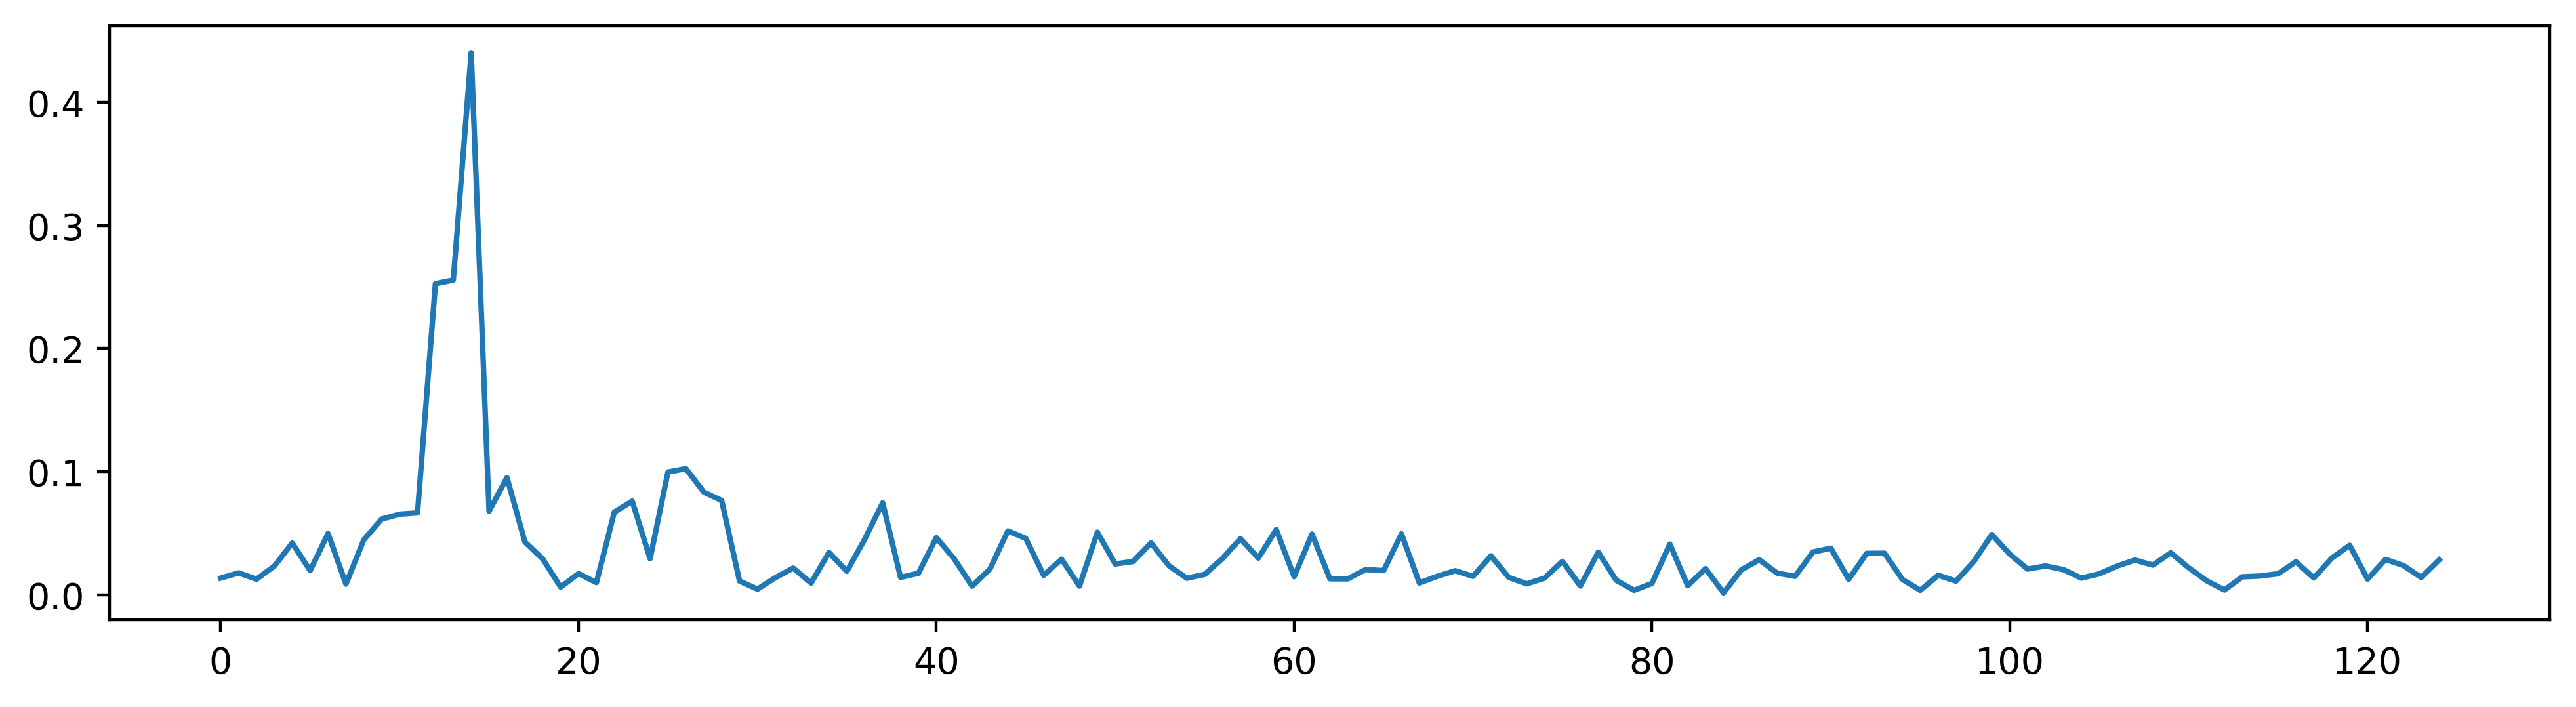

In [102]:
plt.plot(Xf_train[0])

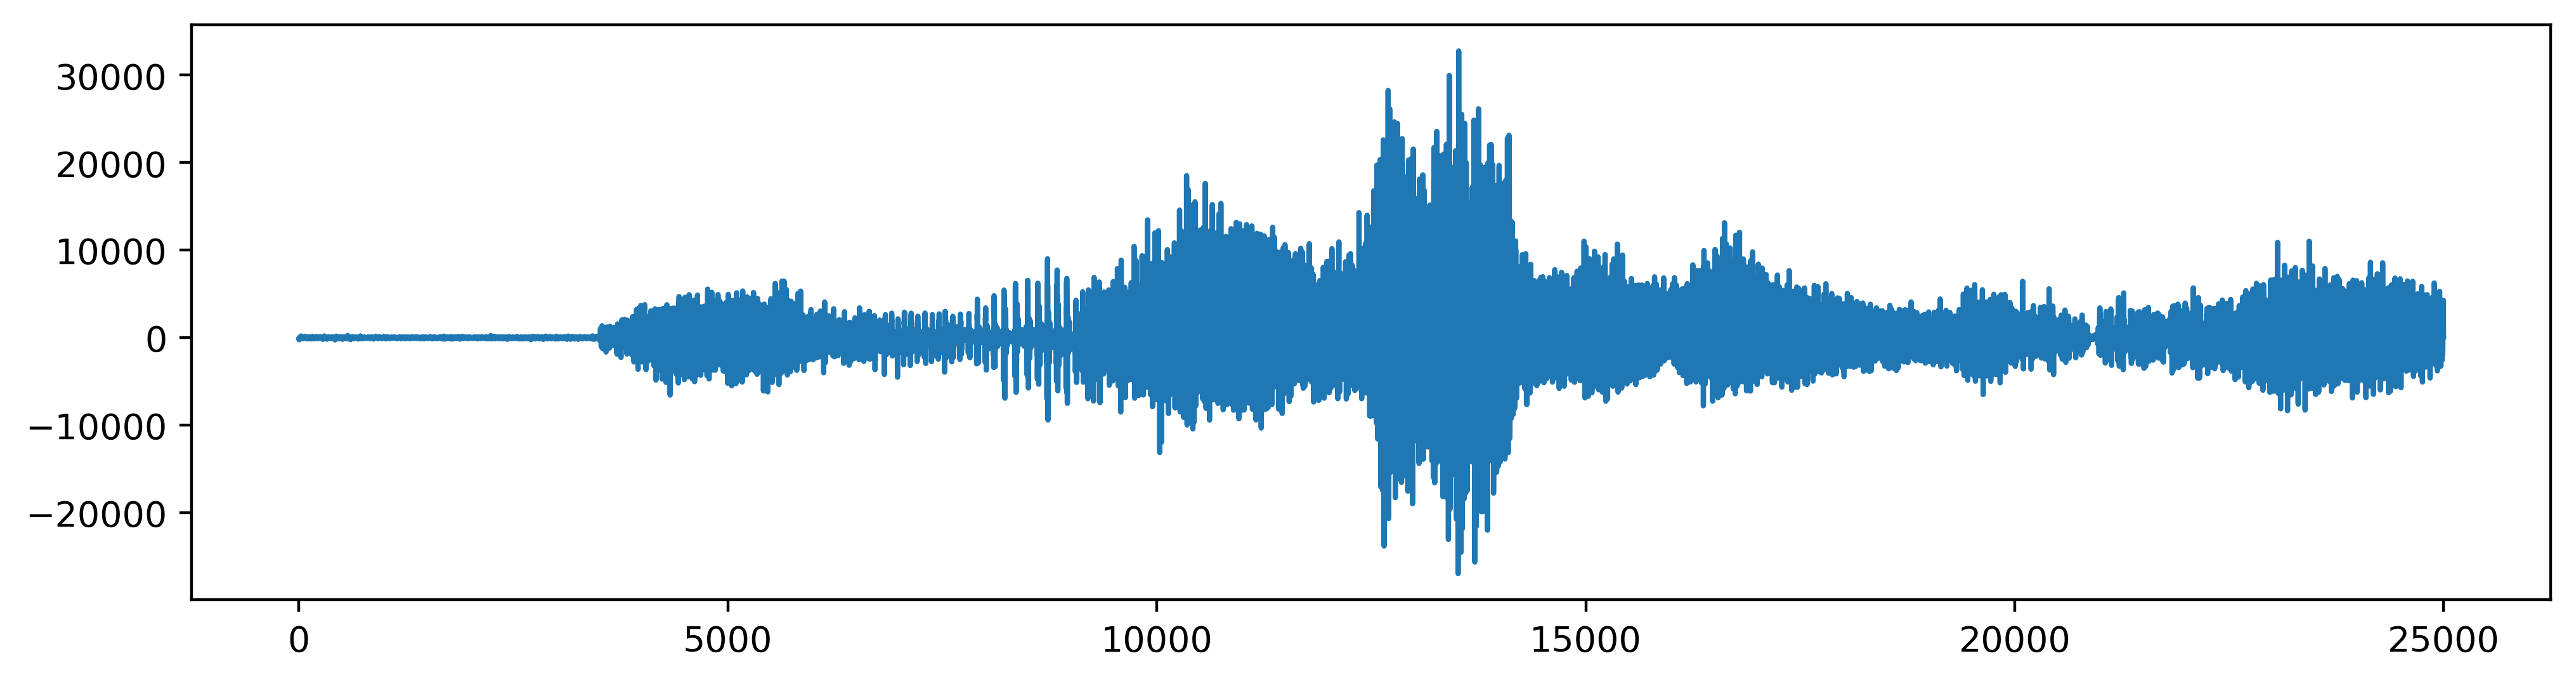

In [104]:
plt.plot(X_train[0])

In [138]:
# Variance of frequency data
Xf_var = np.mean(np.linalg.norm(Xf_train - Xf_train.mean(axis=0))**2)
Xf_var

327.40494866733764

In [140]:
# Variance of raw data
X_var = np.mean(np.linalg.norm(X_train - X_train.mean(axis=0))**2)
X_var

116327992053260.64

In [120]:
np.mean(np.var(X_train, axis=0))

15510398.94043475

In [121]:
np.mean(np.var(Xf_train, axis=0))

0.008730798631129003

# EXTRA STUFF -- PLAYING AROUND

In [ ]:
class SoundWave(object):
    """A class for working with digital audio signals."""


    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        # Set the attributes
        self.rate = rate
        self.samples = samples
        self.num_samples = samples.size


    def plot(self, useDFT=False):
        """Plot the graph of the sound wave (time versus amplitude)."""
        plt.figure()
        if useDFT:
            plt.subplot(122)
            plt.title("Fourier Transform")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            # Correctly set the x axis to be in terms of frequency
            x = np.arange(self.num_samples)*self.rate/self.num_samples
            y = np.abs(fft(self.samples))
            x_end = self.num_samples*self.rate/self.num_samples/2
            #plt.xlim(-.02*x_end,x_end)
            plt.ylim(0,1.075*np.max(y))
            plt.plot(x,y)
            plt.subplot(121)
        
        # Set the y axis limits
        plt.ylim(-32768, 32767)
        plt.title("Sound Wave")
        # Correctly label the x axis in terms of seconds
        x = np.linspace(0,self.num_samples/self.rate,self.num_samples)
        plt.xlabel("Time (s)")
        plt.ylabel("Samples")
        plt.plot(x,self.samples)


    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
        """
        # Note: we convert to int64 so that we can multiply by 
        #  32767, then we convert the result back to int16
        if force:
            samples = np.array(self.samples,dtype=np.int64)
            samples = np.array(32767*samples/np.max(np.abs(samples)),
                               dtype=np.int16)
        elif type(self.samples) is not np.int16:
            samples = np.array(32767*samples/np.max(np.abs(samples)),
                               dtype=np.int16)
        else:
            samples = self.samples

        # Write the samples to a file
        wavfile.write(filename, self.rate, samples)
        

    def __len__(self):
        """Returns the length of the sound file in seconds."""
        return int(round(self.num_samples/self.rate))

    
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        # Make sure they are the same length
        if other.num_samples != self.num_samples:
            raise ValueError("The two sample sounds are not the same length.")
        
        # Get the element-wise sum of the two samples.
        sample1 = np.array(other.samples,dtype=np.int32)
        sample2 = np.array(self.samples,dtype=np.int32)
        summed_wave = sample1 + sample2
        # Scale the sample if necessary
        if np.max(np.abs(summed_wave)) > 32767:
            summed_wave = np.array(summed_wave*32767
                    /np.max(np.abs(summed_wave)),dtype=np.int16)
            
        return SoundWave(self.rate, summed_wave)
        

    # Problem 1.4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        # Error checking
        if other.rate != self.rate:
            raise ValueError("The two samples' rates are not equal.")
        
        return SoundWave(self.rate, np.concatenate((self.samples,other.samples)))
                                   
    
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using circular convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("The sample rates are not equal.")
        
        f = self.samples
        g = other.samples
        if len(f) < len(g):
            f = np.concatenate([f,np.zeros(len(g)-len(f))])
        if len(g) < len(f):
            g = np.concatenate([g,np.zeros(len(f)-len(g))])
            
        f_conv_g = ifft(fft(f)*fft(g)).real
        return SoundWave(self.rate, f_conv_g)

    
    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using linear convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("The sample rates are not equal.")
            
        n,m = self.num_samples, other.num_samples
        
        # Find the smallest 2**a such that 2**a >= n + m - 1
        to_compare = n + m - 1
        a = 0
        while 2**a < to_compare:
            a += 1
        
        # Append zeros to f,g so that both are length 2**a
        f, g = self.samples, other.samples
        f = np.concatenate([f,np.zeros(2**a - n)])
        g = np.concatenate([g,np.zeros(2**a - m)])
        
        out = ifft(fft(f)*fft(g))[:(n+m-1)].real
        return SoundWave(self.rate, out)

    
    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT. 

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher boound of the frequency range to zero out.
        """
        
        a, b = ( int(low_freq/self.rate*self.num_samples), 
                 int(high_freq/self.rate*self.num_samples) )
        
        # Get the frequencies
        freq = fft(self.samples)
        
        # zero them out between the low and high frequency
        freq[a:b] = 0 
        freq[(freq.size-b):(freq.size-a)] = 0
        
        # Convert the frequencies back to the sound wave
        self.samples = ifft(freq).real

In [ ]:
# Some of the test files I can mess around with.
file_ti1 = 'raw_data/tired/03ADDCFB-354E-416D-BF32-260CF47F7060-1433658024-1.1-f-04-ti.wav'
file_ti2 = 'raw_data/tired/06c4cfa2-7fa6-4fda-91a1-ea186a4acc64-1430029221058-1.7-f-26-ti.wav'
file_hu1 = 'raw_data/hungry/02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.wav'
file_hu2 = 'raw_data/hungry/02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.wav'

In [ ]:
SW = SoundWave(*wavfile.read(file_ti2))
SW.plot(useDFT=True)
IPython.display.Audio(filename=file_ti2)

In [ ]:
SW = SoundWave(*wavfile.read(file_hu1))
SW.plot(useDFT=True)
IPython.display.Audio(filename=file_hu1)

In [ ]:
SW2 = SoundWave(*wavfile.read(file_hu2))
SW2.plot(useDFT=True)
IPython.display.Audio(filename=file_hu2)

In [ ]:
SW = SoundWave(*wavfile.read(file_ti1))
SW.plot(useDFT=True)
IPython.display.Audio(filename=file_ti1)

In [ ]:
bare_y = y[::10]
ifftbare_y = ifft(bare_y).real
new_samples = 32767*ifftbare_y/np.max(np.abs(ifftbare_y))
bare_SW = SoundWave(SW.rate//10, new_samples)
bare_SW.plot(useDFT=True)
bare_SW.export('reduced_sound.wav', force=True)

In [ ]:
IPython.display.Audio(filename='reduced_sound.wav')

In [ ]:
x = np.arange(SW.num_samples)*SW.rate/SW.num_samples
y = np.abs(fft(SW.samples))
plt.figure()
plt.plot(x[:len(x)//2], y[:len(x)//2])
plt.title(f'Using {len(x)//2} frequency measurements')
plt.figure()
plt.plot(x[:len(x)//2:10], y[:len(x)//2:10])
plt.title(f'Using {len(x[:len(x)//2:10])} frequency measurements')
plt.figure()
plt.plot(x[:len(x)//2:100], y[:len(x)//2:100])
plt.title(f'Using {len(x[:len(x)//2:100])} frequency measurements')

In [ ]:
# Section to get all the data files.
all_data = []
for folder in ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']:
    all_data.append('raw_data/'+folder)

In [ ]:
data, labels = load_data()
data

In [ ]:
labels

In [ ]:
dup, lab = duplicate_data(data[:2], labels[:2])
dup

In [ ]:
plt.figure()
plt.plot(dup[0][0])

plt.figure()
plt.plot(dup[2][0])

In [ ]:
X = []
lens = set()
for d, _ in data:
    X.append(d)
X = np.array(X)
X

In [ ]:
np.max(X, axis=1)